In [1]:
from importlib import reload
import game2
game2 = reload(game2)
from game2 import Game
import random
import torch
import pandas as pd
import collections
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from IPython.display import clear_output
from torch import nn
from torch.optim import Adam
from torch.distributions import Categorical
from torchvision.transforms import transforms

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 
print(device)

cuda:0


In [3]:
moving_average = lambda x, **kw: pd.DataFrame({'x':np.asarray(x)}).x.ewm(**kw).mean().values

In [4]:
def test_agent(env, agent=None, n_episodes=100):
    """Runs agent for n_episodes in environment and calclates mean reward.
    
    Args:
        env: The environment for agent to play in
        agent: The agent to play with. Defaults to None - 
            in this case random agent is used.
        n_episodes: Number of episodes to play. Defaults to 100.

    Returns:
        Mean reward for 100 episodes.
    """
    total_reward = []
    for episode in range(n_episodes):
        episode_reward = 0
        observation = env.reset()
        done = False
        while not done:
            if agent:
                with torch.no_grad():
                    observation = transform(observation)
                    probs = agent(torch.as_tensor(observation, device=device))
                    dist = Categorical(probs)
                    action = dist.sample().item()
            else:
                action = random.randint(0, 2)
            observation, reward, done, _ = env.step(action)
            episode_reward += reward
        total_reward.append(episode_reward)
    env.stop()
    return np.mean(total_reward)   

In [5]:
env = Game(False)
test_agent(env, agent=False, n_episodes=100)

-0.73

In [32]:
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.reshape(batch_size, -1)

In [33]:
class Policy(nn.Module):
    def __init__(self, in_channels, out_size, h=210, w=160):
      super(Policy, self).__init__()
      def conv2d_size_out(size, kernel_size = 4, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
      
      self.h = h
      self.w = w
      
      convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w, 8, 4)), 3, 1)
      convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h, 8, 4)), 3, 1)
      linear_input = convh * convw * 64
      self.act = nn.Sequential(nn.Conv2d(in_channels, 32, kernel_size=8, stride=4),
                               nn.BatchNorm2d(32),
                               nn.ReLU(),
                               nn.Conv2d(32, 64, kernel_size=4, stride=2),
                               nn.BatchNorm2d(64),
                               nn.ReLU(),
                               nn.Conv2d(64, 64, kernel_size=3, stride=1),
                               nn.BatchNorm2d(64),
                               nn.ReLU(),
                               Flattener(),
                               nn.Linear(linear_input, 1024),
                               nn.ReLU(),
                               nn.Linear(1024, out_size),
                               nn.Softmax(),
                               )
        
    def forward(self, X):
        if len(X.shape) < 4:
            X = X.view(1, X.shape[0], X.shape[1], X.shape[2])
        return self.act(X)

In [34]:
def process_traj_batch(policy, batch, discount):
    """Computes log probabilities for each action 
        and rewards-to-go for each state in the batch of trajectories.
    
    Args:
        policy: Policy of the agent.
        batch (list of list of collections.namedtuple): Batch of trajectories.
        discount (float): Discount factor for rewards-to-go calculation.

    Returns:
        log_probs (list of torch.FloatTensor): List of log probabilities for
            each action in the batch of trajectories.
        returns (list of rewards-to-go): List of rewards-to-go for 
            each state in the batch of trajectories.
    """
    log_probs = []
    returns = []
    
    for episode in batch:
      for numb, step in enumerate(episode):
        returns.append(sum([discount ** i * reward for i, (*_, reward) in enumerate(episode[numb:])]))
        probs = policy(step.state.to(device))
        dist = Categorical(probs)
        log_probs.append((dist.log_prob(step.action)))
    return log_probs, returns


In [48]:
STATE_SIZE  = 8 # размерность пространства состояний среды
ACT_SIZE = 3 # размерность пространства действий среды
HIDDEN_SIZE = 200 # размер скрытого слоя для политики
HIDDEN_SIZE2 = 128
HIDDEN_SIZE3 = 64
NUM_EPISODES = 200 # количество эпиздов, которые будут сыграны для обучения
DISCOUNT = .99 # фактор дисконтирования
TRAIN_EVERY = 24

In [49]:
torch.cuda.empty_cache()
in_channels = 3
hid_channels = 60
out_size = 3
transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.Resize(size=(84, 84)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.44, 0.44, 0.44], std=[0.20,0.20,0.20])]
                               )

In [50]:
policy = Policy(in_channels, out_size, h=84, w=84).to(device)
optimizer = Adam(policy.parameters(), lr=5e-5)

In [51]:
transition = collections.namedtuple("transition", ["state", "action", "reward"])

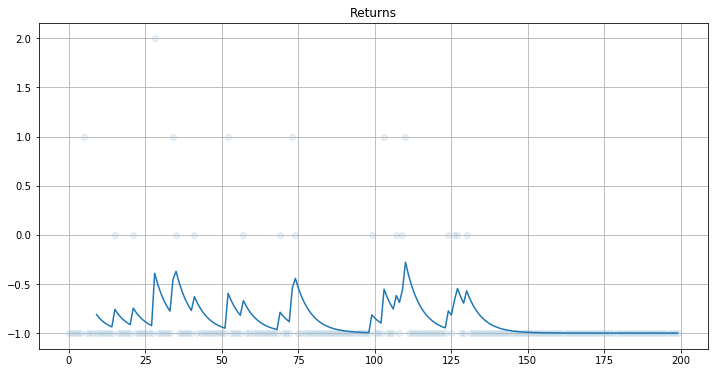

In [52]:
returns_history = []
traj_batch = []
done=False
env = Game(False)
best_model = None
best_rewards = 0

for i in range(NUM_EPISODES):
  state = env.reset()
  traj=[]
  rewards=0
  while not done:
      state = torch.as_tensor(state, dtype=torch.uint8)
      state = transform(state)
      probs = policy.forward(state.to(device))
      action = torch.argmax(probs, dim=-1)
      previos_state = state
      state, reward, done, _ = env.step(action.detach().cpu().numpy())
      rewards += reward
      traj.append(transition(previos_state, action, reward))
  done=False
  returns_history.append(rewards)
  if rewards >= best_rewards:
      best_model = policy
      best_rewards = rewards
  traj_batch.append(traj)

  if (i+1) % TRAIN_EVERY == 0:
      log_probs, returns = process_traj_batch(policy, traj_batch, DISCOUNT)
      loss = -(torch.stack(log_probs) * torch.FloatTensor(returns).to(device)).sum()
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      traj_batch = []

  if (i+1) % 10 == 0:
      clear_output(True)
      plt.figure(figsize=[12, 6])
      plt.title('Returns'); plt.grid()
      plt.scatter(np.arange(len(returns_history)), returns_history, alpha=0.1)
      plt.plot(moving_average(returns_history, span=10, min_periods=10))
      plt.show()

In [53]:
env = Game(True)
test_agent(env, agent=best_model, n_episodes=5)

-0.6